In [ ]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, Model, backend as K
import torch

In [ ]:
tf.__version__

'2.4.1'

In [ ]:
  device = torch.device("cuda")
  print('There are %d GPU(s) available.' % torch.cuda.device_count())
  print('You got a GPU:', torch.cuda.get_device_name(0))

There are 1 GPU(s) available.
You got a GPU: Tesla P100-PCIE-16GB


# Load Data, build DataSet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow import keras

class UzkGenerator_dense(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim1=(7,4096), dim2=(4096,7), dim3=(7), n_channels=1, shuffle=True):
        'Initialization'
        self.dim1 = dim1
        self.dim2 = dim2
        self.dim3 = dim3
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X1 = np.empty((self.batch_size, *self.dim1, self.n_channels))
        X2 = np.empty((self.batch_size, *self.dim2))
        X3 = np.empty((self.batch_size, self.dim3))

        y = np.empty(((self.batch_size), 6), dtype=float)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            mat=np.load('/content/drive/MyDrive/Colab Notebooks/Y-Pro/datafull_npy/' + str(ID) + '.npy')
            X1[i,] = np.expand_dims(mat[:,1:4097],2)
            X2[i,] = mat[:,4097:].T
            X3[i,] = mat[:,0]
            # Store class
            y[i] = self.labels[ID]
            X=[X1,X2,X3]
            
        return X, y

In [ ]:
lable=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Y-Pro/velotar.csv')
tlable=lable.shift(1).reindex([i for i in range(1,1279)])
tlable.iloc[-1,:]=lable.iloc[-1,:]
target_dict={}
for i in tlable.index:
    target_dict[i]=tlable.loc[i,:].values
  

In [ ]:
full_id_list=[i for i in range(1,1279)]

In [ ]:
random.shuffle(full_id_list)

In [ ]:
params = {'dim': (32, 4097),
          'batch_size': 32,
          'n_channels': 1,
          'shuffle': True}
training_generator = UzkGenerator_dense(full_id_list[0:1000], target_dict)
validation_generator = UzkGenerator_dense(full_id_list[1000:1277], target_dict)

In [ ]:
training_generator[0][0][2].shape

(32, 7)

# **Model**

In [ ]:
inp_seismo=layers.Input(shape=(7, 4096, 1))

s2d=layers.Conv2D(64, kernel_size=(1,16), strides=(1, 4), padding='same')(inp_seismo)
s2d=layers.BatchNormalization()(s2d)
s2d=layers.Activation('relu')(s2d)
s2d=layers.MaxPool2D(pool_size=(1, 8), strides=(1,2), padding='same')(s2d)

s2d1=layers.BatchNormalization()(s2d)
s2d1=layers.Activation('relu')(s2d1)
s2d1=layers.Conv2D(128, kernel_size=(2,8), strides=(1, 1), padding='same')(s2d1)
s2d1=layers.BatchNormalization()(s2d1)
s2d1=layers.Activation('relu')(s2d1)
s2d1=layers.Conv2D(64, kernel_size=(2,8), strides=(1, 1), padding='same')(s2d1)

s2d1=layers.Concatenate(axis=3)([s2d,s2d1])

s2d2=layers.BatchNormalization()(s2d1)
s2d2=layers.Activation('relu')(s2d2)
s2d2=layers.Conv2D(128, kernel_size=(2,8), strides=(1, 1), padding='same')(s2d2)
s2d2=layers.BatchNormalization()(s2d2)
s2d2=layers.Activation('relu')(s2d2)
s2d2=layers.Conv2D(64, kernel_size=(2,8), strides=(1, 1), padding='same')(s2d2)

s2d2=layers.Concatenate(axis=3)([s2d1,s2d2])

s2d3=layers.BatchNormalization()(s2d2)
s2d3=layers.Activation('relu')(s2d3)
s2d3=layers.Conv2D(128, kernel_size=(2,8), strides=(1, 1), padding='same')(s2d3)
s2d3=layers.BatchNormalization()(s2d3)
s2d3=layers.Activation('relu')(s2d3)
s2d3=layers.Conv2D(64, kernel_size=(2,8), strides=(1, 1), padding='same')(s2d3)

s2d3=layers.Concatenate(axis=3)([s2d2,s2d3])

s2d4=layers.BatchNormalization()(s2d3)
s2d4=layers.Activation('relu')(s2d4)
s2d4=layers.Conv2D(128, kernel_size=(2,8), strides=(1, 1), padding='same')(s2d4)
s2d4=layers.BatchNormalization()(s2d4)
s2d4=layers.Activation('relu')(s2d4)
s2d4=layers.Conv2D(64, kernel_size=(2,8), strides=(1, 1), padding='same')(s2d4)

s2d4=layers.Concatenate(axis=3)([s2d3,s2d4])

s2d5=layers.BatchNormalization()(s2d4)
s2d5=layers.Activation('relu')(s2d5)
s2d5=layers.Conv2D(128, kernel_size=(2,8), strides=(1, 1), padding='same')(s2d5)
s2d5=layers.BatchNormalization()(s2d5)
s2d5=layers.Activation('relu')(s2d5)
s2d5=layers.Conv2D(64, kernel_size=(2,8), strides=(1, 1), padding='same')(s2d5)

s2d5=layers.Concatenate(axis=3)([s2d4,s2d5])

s2d6=layers.BatchNormalization()(s2d5)
s2d6=layers.Activation('relu')(s2d6)
s2d6=layers.Conv2D(128, kernel_size=(2,8), strides=(1, 1), padding='same')(s2d6)
s2d6=layers.BatchNormalization()(s2d6)
s2d6=layers.Activation('relu')(s2d6)
s2d6=layers.Conv2D(64, kernel_size=(2,8), strides=(1, 1), padding='same')(s2d6)

s2d6=layers.Concatenate(axis=3)([s2d5,s2d6])

s2d7=layers.BatchNormalization()(s2d6)
s2d7=layers.Activation('relu')(s2d7)
s2d7=layers.Conv2D(128, kernel_size=(2,8), strides=(1, 1), padding='same')(s2d7)
s2d7=layers.BatchNormalization()(s2d7)
s2d7=layers.Activation('relu')(s2d7)
s2d7=layers.Conv2D(64, kernel_size=(2,8), strides=(1, 1), padding='same')(s2d7)

s2d7=layers.Concatenate(axis=3)([s2d6,s2d7])

s2d8=layers.BatchNormalization()(s2d7)
s2d8=layers.Activation('relu')(s2d8)
s2d8=layers.Conv2D(128, kernel_size=(2,8), strides=(1, 1), padding='same')(s2d8)
s2d8=layers.BatchNormalization()(s2d8)
s2d8=layers.Activation('relu')(s2d8)
s2d8=layers.Conv2D(64, kernel_size=(2,8), strides=(1, 1), padding='same')(s2d8)

s2d8=layers.Concatenate(axis=3)([s2d7,s2d8])

s2d9=layers.BatchNormalization()(s2d8)
s2d9=layers.Activation('relu')(s2d9)
s2d9=layers.Conv2D(128, kernel_size=(2,8), strides=(1, 1), padding='same')(s2d9)
s2d9=layers.BatchNormalization()(s2d9)
s2d9=layers.Activation('relu')(s2d9)
s2d9=layers.Conv2D(64, kernel_size=(2,8), strides=(1, 1), padding='same')(s2d9)

s2d9=layers.Concatenate(axis=3)([s2d8,s2d9])

s2d10=layers.BatchNormalization()(s2d9)
s2d10=layers.Activation('relu')(s2d10)
s2d10=layers.Conv2D(128, kernel_size=(2,8), strides=(1, 1), padding='same')(s2d10)
s2d10=layers.BatchNormalization()(s2d10)
s2d10=layers.Activation('relu')(s2d10)
s2d10=layers.Conv2D(64, kernel_size=(2,8), strides=(1, 1), padding='same')(s2d10)

s2d10=layers.Concatenate(axis=3)([s2d9,s2d10])

s2d11=layers.BatchNormalization()(s2d10)
s2d11=layers.Activation('relu')(s2d11)
s2d11=layers.Conv2D(128, kernel_size=(2,8), strides=(1, 1), padding='same')(s2d11)
s2d11=layers.BatchNormalization()(s2d11)
s2d11=layers.Activation('relu')(s2d11)
s2d11=layers.Conv2D(64, kernel_size=(2,8), strides=(1, 1), padding='same')(s2d11)

s2d11=layers.Concatenate(axis=3)([s2d10,s2d11])

s2d12=layers.BatchNormalization()(s2d11)
s2d12=layers.Activation('relu')(s2d12)
s2d12=layers.Conv2D(128, kernel_size=(2,8), strides=(1, 1), padding='same')(s2d12)
s2d12=layers.BatchNormalization()(s2d12)
s2d12=layers.Activation('relu')(s2d12)
s2d12=layers.Conv2D(64, kernel_size=(2,8), strides=(1, 1), padding='same')(s2d12)

s2d12=layers.Concatenate(axis=3)([s2d11,s2d12])

s2d13=layers.BatchNormalization()(s2d12)
s2d13=layers.Activation('relu')(s2d13)
s2d13=layers.Conv2D(128, kernel_size=(2,8), strides=(1, 1), padding='same')(s2d13)
s2d13=layers.BatchNormalization()(s2d13)
s2d13=layers.Activation('relu')(s2d13)
s2d13=layers.Conv2D(64, kernel_size=(2,8), strides=(1, 1), padding='same')(s2d13)

s2d13=layers.Concatenate(axis=3)([s2d12,s2d13])

s2d13=layers.BatchNormalization()(s2d13)
s2d13=layers.Activation('relu')(s2d13)

out_seismo=layers.GlobalAveragePooling2D()(s2d13)


input_spectr=layers.Input(shape=(4096, 7))

sp1d=layers.Conv1D(98, 16, strides=8, padding='same')(input_spectr)
sp1d=layers.BatchNormalization()(sp1d)
sp1d=layers.Activation('relu')(sp1d)
sp1d=layers.MaxPool1D(pool_size=8, strides=2, padding='same')(sp1d)

sp1d1=layers.BatchNormalization()(sp1d)
sp1d1=layers.Activation('relu')(sp1d1)
sp1d1=layers.Conv1D(196, kernel_size=16, strides=1, padding='same')(sp1d1)
sp1d1=layers.BatchNormalization()(sp1d1)
sp1d1=layers.Activation('relu')(sp1d1)
sp1d1=layers.Conv1D(98, kernel_size=16, strides=1, padding='same')(sp1d1)

sp1d1=layers.Concatenate(axis=2)([sp1d,sp1d1])

sp1d2=layers.BatchNormalization()(sp1d1)
sp1d2=layers.Activation('relu')(sp1d1)
sp1d2=layers.Conv1D(196, kernel_size=16, strides=1, padding='same')(sp1d2)
sp1d2=layers.BatchNormalization()(sp1d2)
sp1d2=layers.Activation('relu')(sp1d2)
sp1d2=layers.Conv1D(98, kernel_size=16, strides=1, padding='same')(sp1d2)

sp1d2=layers.Concatenate(axis=2)([sp1d1,sp1d2])

sp1d3=layers.BatchNormalization()(sp1d2)
sp1d3=layers.Activation('relu')(sp1d3)
sp1d3=layers.Conv1D(196, kernel_size=16, strides=1, padding='same')(sp1d3)
sp1d3=layers.BatchNormalization()(sp1d3)
sp1d3=layers.Activation('relu')(sp1d3)
sp1d3=layers.Conv1D(98, kernel_size=16, strides=1, padding='same')(sp1d3)

sp1d3=layers.Concatenate(axis=2)([sp1d2,sp1d3])

sp1d4=layers.BatchNormalization()(sp1d3)
sp1d4=layers.Activation('relu')(sp1d4)
sp1d4=layers.Conv1D(196, kernel_size=16, strides=1, padding='same')(sp1d4)
sp1d4=layers.BatchNormalization()(sp1d4)
sp1d4=layers.Activation('relu')(sp1d4)
sp1d4=layers.Conv1D(98, kernel_size=16, strides=1, padding='same')(sp1d4)

sp1d4=layers.Concatenate(axis=2)([sp1d3,sp1d4])

sp1d5=layers.BatchNormalization()(sp1d4)
sp1d5=layers.Activation('relu')(sp1d5)
sp1d5=layers.Conv1D(196, kernel_size=16, strides=1, padding='same')(sp1d5)
sp1d5=layers.BatchNormalization()(sp1d5)
sp1d5=layers.Activation('relu')(sp1d5)
sp1d5=layers.Conv1D(98, kernel_size=16, strides=1, padding='same')(sp1d5)

sp1d5=layers.Concatenate(axis=2)([sp1d4,sp1d5])

sp1d6=layers.BatchNormalization()(sp1d5)
sp1d6=layers.Activation('relu')(sp1d6)
sp1d6=layers.Conv1D(196, kernel_size=16, strides=1, padding='same')(sp1d6)
sp1d6=layers.BatchNormalization()(sp1d6)
sp1d6=layers.Activation('relu')(sp1d6)
sp1d6=layers.Conv1D(98, kernel_size=16, strides=1, padding='same')(sp1d6)

sp1d6=layers.Concatenate(axis=2)([sp1d5,sp1d6])

sp1d7=layers.BatchNormalization()(sp1d6)
sp1d7=layers.Activation('relu')(sp1d7)
sp1d7=layers.Conv1D(196, kernel_size=16, strides=1, padding='same')(sp1d7)
sp1d7=layers.BatchNormalization()(sp1d7)
sp1d7=layers.Activation('relu')(sp1d7)
sp1d7=layers.Conv1D(98, kernel_size=16, strides=1, padding='same')(sp1d7)

sp1d7=layers.Concatenate(axis=2)([sp1d6,sp1d7])

sp1d8=layers.BatchNormalization()(sp1d7)
sp1d8=layers.Activation('relu')(sp1d8)
sp1d8=layers.Conv1D(196, kernel_size=16, strides=1, padding='same')(sp1d8)
sp1d8=layers.BatchNormalization()(sp1d8)
sp1d8=layers.Activation('relu')(sp1d8)
sp1d8=layers.Conv1D(98, kernel_size=16, strides=1, padding='same')(sp1d8)

sp1d8=layers.Concatenate(axis=2)([sp1d7,sp1d8])

sp1d9=layers.BatchNormalization()(sp1d8)
sp1d9=layers.Activation('relu')(sp1d9)
sp1d9=layers.Conv1D(196, kernel_size=16, strides=1, padding='same')(sp1d9)
sp1d9=layers.BatchNormalization()(sp1d9)
sp1d9=layers.Activation('relu')(sp1d9)
sp1d9=layers.Conv1D(98, kernel_size=16, strides=1, padding='same')(sp1d9)

sp1d9=layers.Concatenate(axis=2)([sp1d8,sp1d9])

sp1d10=layers.BatchNormalization()(sp1d9)
sp1d10=layers.Activation('relu')(sp1d10)
sp1d10=layers.Conv1D(196, kernel_size=16, strides=1, padding='same')(sp1d10)
sp1d10=layers.BatchNormalization()(sp1d10)
sp1d10=layers.Activation('relu')(sp1d10)
sp1d10=layers.Conv1D(98, kernel_size=16, strides=1, padding='same')(sp1d10)

sp1d10=layers.Concatenate(axis=2)([sp1d9,sp1d10])

sp1d11=layers.BatchNormalization()(sp1d10)
sp1d11=layers.Activation('relu')(sp1d11)
sp1d11=layers.Conv1D(196, kernel_size=16, strides=1, padding='same')(sp1d11)
sp1d11=layers.BatchNormalization()(sp1d11)
sp1d11=layers.Activation('relu')(sp1d11)
sp1d11=layers.Conv1D(98, kernel_size=16, strides=1, padding='same')(sp1d11)

sp1d11=layers.Concatenate(axis=2)([sp1d10,sp1d11])

sp1d12=layers.BatchNormalization()(sp1d11)
sp1d12=layers.Activation('relu')(sp1d12)
sp1d12=layers.Conv1D(196, kernel_size=16, strides=1, padding='same')(sp1d12)
sp1d12=layers.BatchNormalization()(sp1d12)
sp1d12=layers.Activation('relu')(sp1d12)
sp1d12=layers.Conv1D(98, kernel_size=16, strides=1, padding='same')(sp1d12)

sp1d12=layers.Concatenate(axis=2)([sp1d11,sp1d12])

sp1d13=layers.BatchNormalization()(sp1d12)
sp1d13=layers.Activation('relu')(sp1d13)
sp1d13=layers.Conv1D(196, kernel_size=16, strides=1, padding='same')(sp1d13)
sp1d13=layers.BatchNormalization()(sp1d13)
sp1d13=layers.Activation('relu')(sp1d13)
sp1d13=layers.Conv1D(98, kernel_size=16, strides=1, padding='same')(sp1d13)

sp1d13=layers.Concatenate(axis=2)([sp1d12,sp1d13])

sp1d13=layers.BatchNormalization()(sp1d13)
sp1d13=layers.Activation('relu')(sp1d13)

out_spectr=layers.GlobalAveragePooling1D()(sp1d13)

inp_dist=layers.Input(shape=(7))

l=layers.Concatenate(axis=1)([inp_dist,out_seismo,out_spectr])
l=layers.Dense(1024,activation='relu')(l)
l=layers.Dense(128,activation='relu')(l)

output = layers.Dense(6, activation='linear')(l)

model=Model([inp_seismo,input_spectr, inp_dist], output)

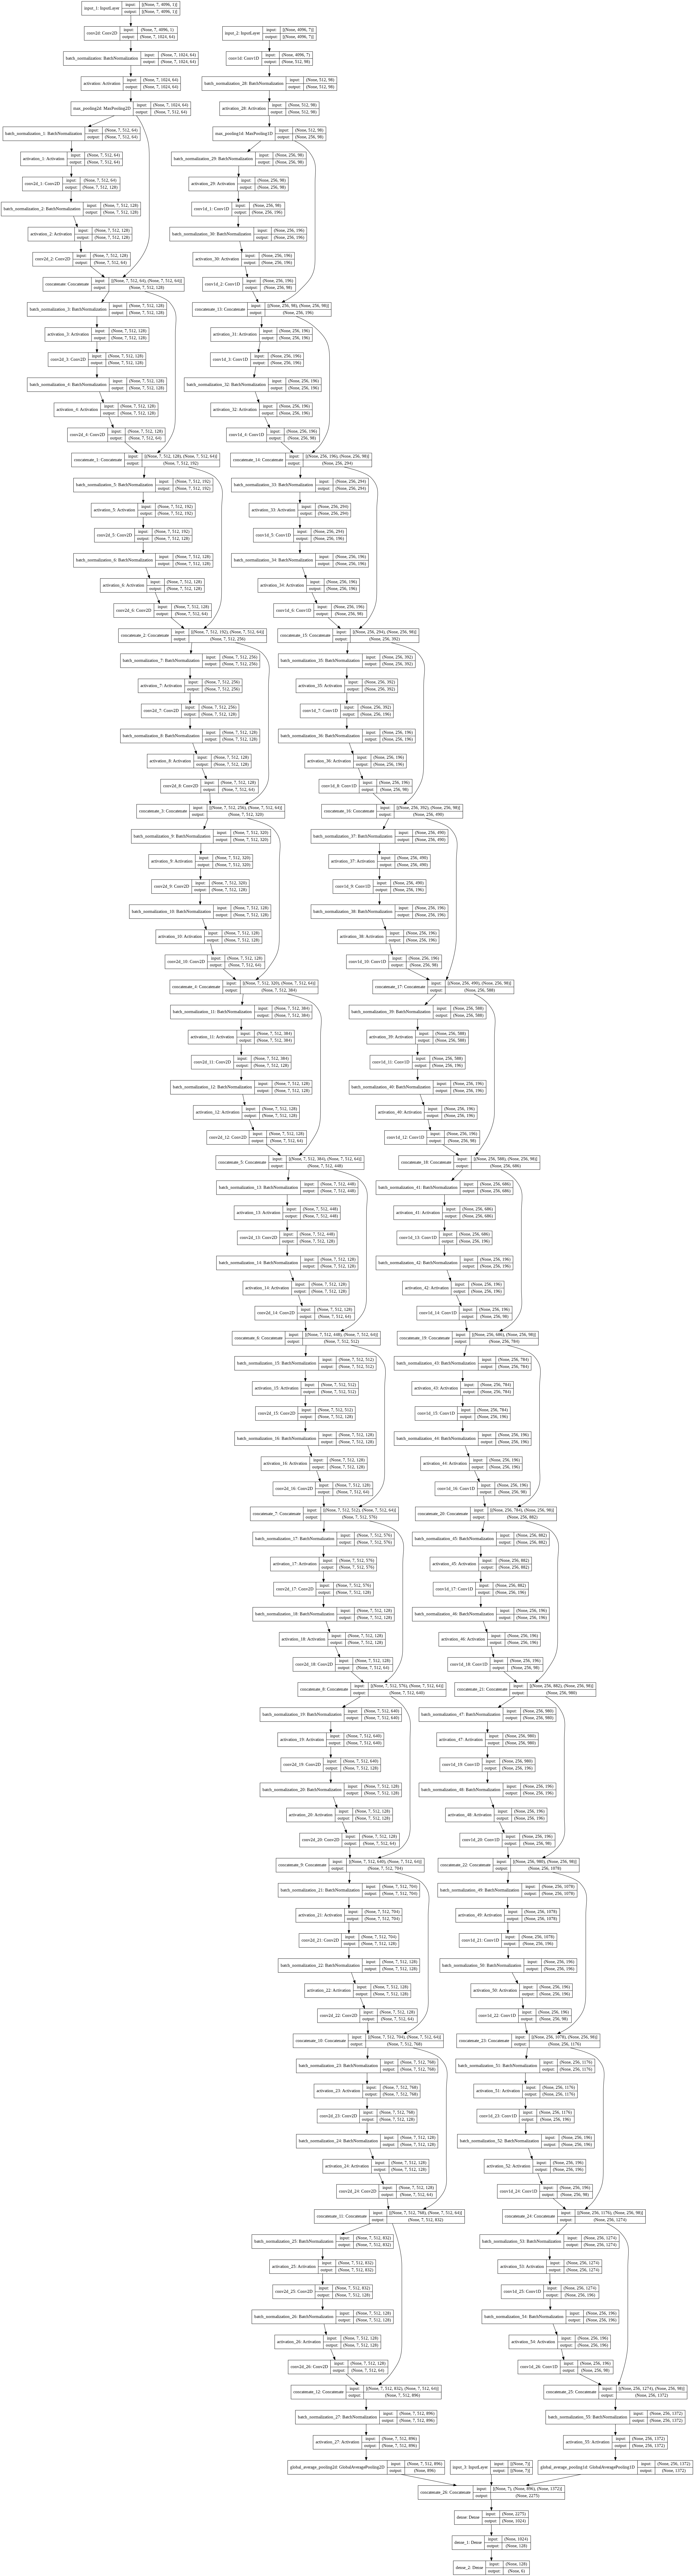

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7, 4096, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 7, 1024, 64)  1088        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096, 7)]    0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 7, 1024, 64)  256         conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
model.inputs

[<KerasTensor: shape=(None, 7, 4096, 1) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 4096, 7) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'input_3')>]

# **Fit + Save**

In [ ]:
model.compile(
            optimizer='adam', 
            loss='MSE', 
            metrics=[tf.keras.metrics.RootMeanSquaredError(),'MAE','MAPE'])

In [ ]:
history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=-1,
                    verbose=2,
                    epochs=150)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
31/31 - 1593s - loss: 3.7817 - root_mean_squared_error: 1.9447 - MAE: 0.9574 - MAPE: 22.4187 - val_loss: 21883.4180 - val_root_mean_squared_error: 147.9305 - val_MAE: 147.5140 - val_MAPE: 3669.5776
Epoch 2/150
31/31 - 89s - loss: 2.6101 - root_mean_squared_error: 1.6156 - MAE: 0.6586 - MAPE: 15.5191 - val_loss: 371.3499 - val_root_mean_squared_error: 19.2704 - val_MAE: 18.0152 - val_MAPE: 451.3003
Epoch 3/150
31/31 - 70s - loss: 2.5746 - root_mean_squared_error: 1.6045 - MAE: 0.6394 - MAPE: 15.2060 - val_loss: 2.1544 - val_root_mean_squared_error: 1.4678 - val_MAE: 1.1944 - val_MAPE: 32.9657
Epoch 4/150
31/31 - 66s - loss: 2.6110 - root_mean_squared_error: 1.6159 - MAE: 0.6734 - MAPE: 15.8647 - val_loss: 7.4504 - val_root_mean_squared_error: 2.7295 - val_MAE: 2.4328 - val_MAPE: 65.1295
Epoch 5/150
31/31 - 66s - loss: 2.5093 - root_mean_squared_error: 1.5841 - MAE: 0.6170 - MAPE: 14.4942 - val_loss: 1.4407 - val_root_mean_squared_error: 1.2003 - val_MAE: 0.8630 - val_MAPE: 2

Lerning curve

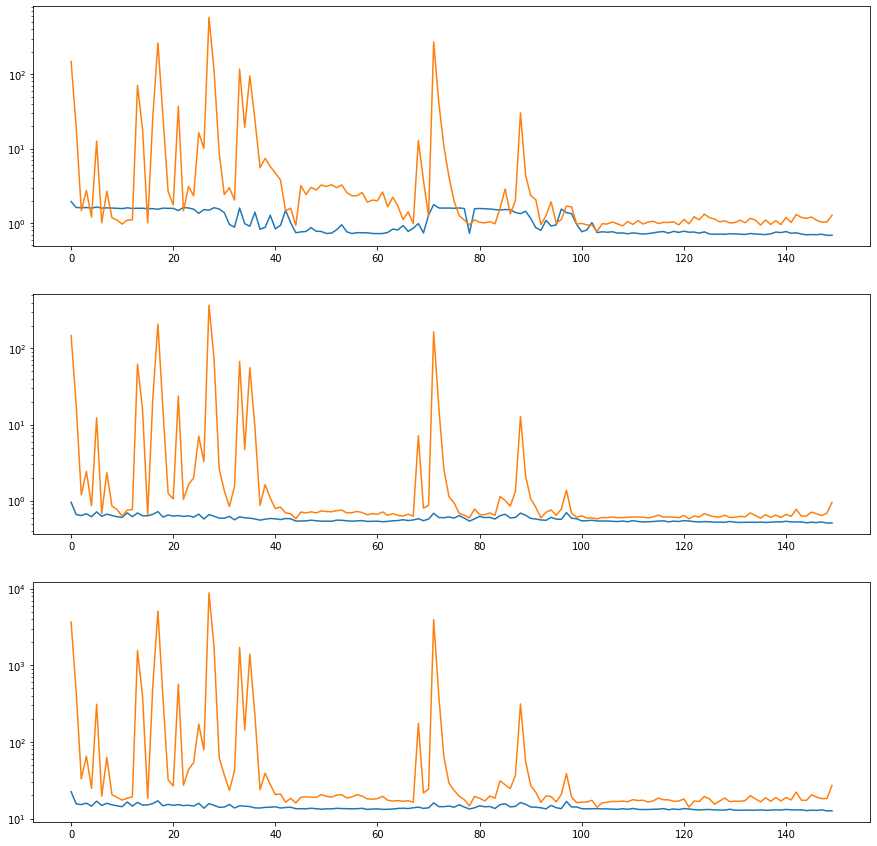

In [ ]:
import matplotlib.pyplot as plt
fig, ax =plt.subplots(nrows=3, figsize=(15, 15))

ax[0].set_yscale('log')
ax[0].plot(history.history['root_mean_squared_error'])
ax[0].plot(history.history['val_root_mean_squared_error'])

ax[1].set_yscale('log')
ax[1].plot(history.history['MAE'])
ax[1].plot(history.history['val_MAE'])

ax[2].set_yscale('log')
ax[2].plot(history.history['MAPE'])
ax[2].plot(history.history['val_MAPE'])

Save model

In [ ]:
path_to_save='/content/drive/MyDrive/Colab Notebooks/Model_2_Densenet'
model.save(path_to save)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Y-Pro/Model_2_Densenet/assets
